In [1]:
### Checked that TS doesn't collapse if sources are added: Hmm, not sure yet exactly what's going on

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import healpy as hp
import pickle

import histlite as hl
import csky as cy

from scipy import stats

%matplotlib inline

In [2]:
plt.style.use('../matplotlib_style')

In [1]:
ana_dir = '/home/pcoppin/csky_notebooks/TESTDIR'

In [4]:
#ana = cy.get_analysis(cy.selections.repo, cy.selections.GFUDataSpecs.gfu_IC86, dir=ana_dir)
ana = cy.get_analysis(cy.selections.repo, cy.selections.PSDataSpecs.ps_2011, dir=ana_dir)

#ana.save(ana_dir)

Setting up Analysis for:
IC86_2011
Setting up IC86_2011...
Reading /data/ana/analyses/ps_tracks/current/IC86_2011_MC.npy ...
Reading /data/ana/analyses/ps_tracks/current/IC86_2011_exp.npy ...
Reading /data/ana/analyses/ps_tracks/current/GRL/IC86_2011_exp.npy ...
<- /home/pcoppin/csky_notebooks/TESTDIR/IC86_2011.subanalysis.npy    
Done.


In [5]:
a        = ana.anas[0]
ds       = a.ds           # ds: dataset
data     = a.data

bg_data     = a.bg_data
sig         = a.sig
livetime    = a.livetime
bg_livetime = a.bg_livetime
grl         = a.grl
mjd_range   = [a.mjd_min, a.mjd_max]

zenith_bins = a.kw_space_bg['hkw']["bins"]

In [6]:
Configuration = {'ana': ana,
                 'space': "ps",
                 'time': "transient",
                 'sig': 'transient',
                 'energy': "customflux",
                 'flux': cy.hyp.PowerLawFlux(2),
                 'bg_param': cy.pdf.BgAzimuthSinDecParameterization(a.bg_data, smooth=(1,4), hkw=a.kw_space_bg['hkw']),
                 'cut_n_sigma': 5,
                 'mp_cpus': 5,
                 'extended': True}   # Use an extended likelihood, i.e. including a Poissonian term

cy.CONF.update(Configuration)

In [17]:
N_srcs = 1
ran = np.random.RandomState(seed=5239)
src_mjds = ran.uniform(a.mjd_min+10, a.mjd_max-10, N_srcs)
src_ras = ran.uniform(0, 2*np.pi, N_srcs)
src_decs = ran.uniform(-0.5*np.pi, 0.5*np.pi, N_srcs)
src_t100s = ran.uniform(0.2, 0.8, N_srcs)

src = cy.utils.Sources(ra=src_ras, dec=src_decs, mjd=src_mjds, sigma_t=np.zeros((len(src_ras))), t_100=src_t100s, extension=np.zeros((len(src_ras))))

In [197]:
# for key in src.keys():
#     print(key)
#     print(src[key])
#     print()
src = cy.utils.Sources(ra=[0.91668162, 4.04814167, 2.74595039, 4.23008209, 5.03080606, 1.96223473, 3.87815248, 5.15003109, 1.72646452, 2.84146484],
                       dec=[-1.16047679, 0.96948654, -0.6776547, 0.510607, -0.30790527, 1.25675768, 0.51993802, -0.91140132, -0.65187073, -0.16032772],
                       mjd=[55904.75139009, 55799.73504639, 55740.10736078, 55741.83147753, 55741.36060262, 55967.32804137, 55985.72273753, 56019.47500169, 55868.86090543, 55837.34996367],
                       sigma_t=[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
                       t_100=[0.73503302, 0.6158417, 0.53207519, 0.58095649, 0.52194223, 0.2076263, 0.52491778, 0.51386926, 0.41912883, 0.44362005],
                       extension=[0.03490659, 0.03490659, 0.03490659, 0.03490659, 0.03490659, 0.03490659, 0.03490659, 0.03490659, 0.03490659, 0.03490659])

In [162]:
one_GRB = True
if( one_GRB ): # Doesnt give a nice dist  --> Because the extension is too small... See if this really is a problem and why it differs so much from the sp one
    #src = cy.utils.Sources(ra=[34.82], dec=[43.21], deg=True , mjd=[55776.1234], sigma_t=[0.0/86400], t_100=[1e6/86400], name=["Fake_GRB"], extension=[2.0], t_start=[55776.0234], t_stop=[55776.5234])
    
    
    src = pickle.load(open("random_10_srcs.pickle", "rb"))
    src.__setitem__("extension", np.radians(2)*np.ones((len(src))))
    src._unset('prior')
    
#     N = 10
#     duration = 4e4/86400.0#/N
#     src = cy.utils.Sources(ra=[34.82], dec=[43.21], deg=True , mjd=[55776.1234], sigma_t=[0.0/86400], t_100=[duration], extension=[2.0], t_start=[55776.0234], t_stop=[55776.5234])
#     for i in range(1, N):
#         src = src + cy.utils.Sources(ra=[34.82], dec=[43.21], deg=True , mjd=[55776.1234+i], sigma_t=[0.0/86400], t_100=[duration],
#                                      extension=[2.0], t_start=[55776.0234+i], t_stop=[55776.5234+i])
    #src = src[:]
    #src._set("weight", np.ones((len(src)))/len(src))
else: # Gives a nice dist
    import sqlite3
    import pandas
    import numpy as np
    db = sqlite3.connect("/home/pcoppin/csky_notebooks/GRB_data/GRBweb2.sqlite")
    query = "Select * from Summary where GRB_name_Fermi like 'GRB11%'"
    for i in range(2, 10):
         query += " OR GRB_name_Fermi like 'GRB1{}%'".format(i)
    query += ";"
    table = pandas.read_sql_query(query, db)
    table = table[table.mjd>mjd_range[0]]
    table = table[table.mjd<mjd_range[1]]
    data_file = np.load("/home/pcoppin/csky_notebooks/GRB_data/Emission_times.npz")
    Emission_times = data_file["Emission_times"].item()
    t_prompt_start = {}
    for key in Emission_times:
        t, p = Emission_times[key]
        if( t is not None ):
            t_prompt_start[key.replace("bn", "GRB")] = t
    T = table[table.GRB_name_Fermi.isin(t_prompt_start)]
    print(len(T))
    T = T[:20]    # limit the number of sources
    Names = np.array(T.GRB_name_Fermi, dtype=str)
    t_active_start = []
    t_start = []
    t_stop  = []
    extension = []#
    for name in Names:
        mjd       = float(T.mjd[T.GRB_name_Fermi==name])
        T100      = float(T.T100[T.GRB_name_Fermi==name])
        t_prompt  = t_prompt_start[name]
        pos_error = float(T.pos_error[T.GRB_name_Fermi==name])
        ext       = None
        mjd_prompt = mjd + t_prompt/86400
        t_active_start.append(mjd_prompt - 500/86400)
        t_start.append(mjd_prompt-500/86400)
        t_stop.append( mjd_prompt)
        if( np.isnan(pos_error) ):
            extension.append(10)
        else:
            extension.append(pos_error)
    #extension = np.radians(extension) Can be given in degrees if "deg=True"
    # Define the sources
    src = cy.utils.Sources(ra=np.array(T.ra), dec=np.array(T.decl), deg=True, extension=extension, mjd=np.array(t_active_start), # Note that MJD & T100 will be changed when comparing different time windows
                           t_100=np.repeat(500/86400.0,len(Names)), name=Names, sigma_t=np.repeat(0,len(Names)), t_start=np.array(t_start), t_stop=np.array(t_stop))
    print(len(src))

#src["t_100"] = 1e5/86400.0*np.ones((len(src)))
#src["weight"] = np.ones((len(src)))

In [18]:
trtr = cy.get_trial_runner(src=src)

In [19]:
trtr.get_one_fit(0, seed=2364, _full_output=True)

(0.0,
 {'ns': 0.0},
 {},
 {'_fit_null': False,
  '_fmin_epsilon': 1e-08,
  '_fmin_factr': 1000000000.0,
  '_fmin_method': 'l_bfgs_b',
  '_full_output': True,
  '_log_params': [],
  '_masks': None,
  '_ns_min': 0,
  '_ns_tol': 0.0001,
  '_seed_with_null': False,
  '_seed_with_prior': True,
  '_taylor_tol': 0.001,
  '_ts_min': 0})

### Look at the bg TS distribution

In [20]:
%time bg_fits = trtr.get_many_fits(10000, mp_cpus=10, seed=20)
bg = cy.dists.Chi2TSD (bg_fits, floc=0)
print(bg)
max(bg.trials.ts)

Performing 10000 background trials using 10 cores:
      10000/10000 trials complete.   
CPU times: user 14.8 ms, sys: 101 ms, total: 116 ms
Wall time: 3.15 s
Chi2TSD(10000 trials, eta=0.047, ndof=1.554, median=0.000 (from fit 0.000))


12.270822957517627

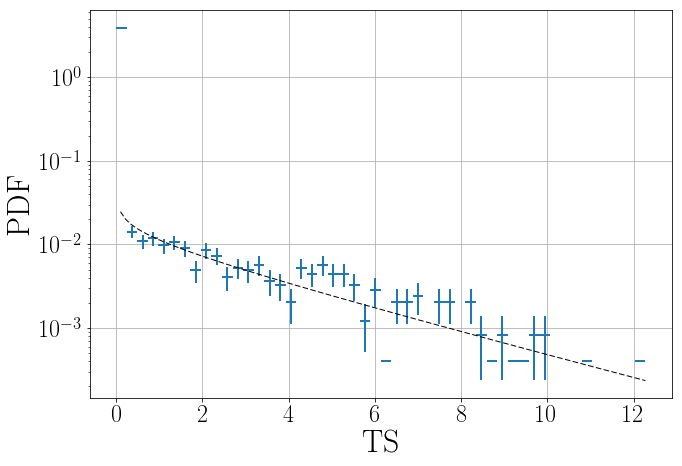

In [21]:
fig, ax = plt.subplots()
h = bg.get_hist (bins=50)
hl.plot1d (ax, h.normalize (), crosses=True)
x = np.linspace (.1, h.range[0][-1], 100)
ax.semilogy (x, bg.eta * bg.chi2.pdf (x), 'k--', lw=1)
plt.xlabel("TS")
plt.ylabel("PDF")
#plt.xlim(0,15)
#plt.ylim(1e-4, 10)
plt.tight_layout()
plt.show()

### Check for a bias in the fit for ns

In [23]:
nss_fit  = []
nss_true = []
ns_range = []
medians  = []
means    = []
N_trials = 5000
step_size = 2
max_ns    = 9
for ns_true in xrange(0, max_ns, step_size):
    out = trtr.get_many_fits(N_trials, n_sig=ns_true, mp_cpus=10)
    ns_fit = out.ns
    nss_fit.extend(out.ns)
    median, mean = np.median(ns_fit), np.mean(ns_fit)
    means.append(mean)
    medians.append(median)
    nss_true.extend(ns_true*np.ones((len(out.ns))))
    ns_range.append(ns_true)

Performing 5000 background trials using 10 cores:
       5000/5000 trials complete.   
Performing 5000 trials with n_sig = 2.000 using 10 cores:
       5000/5000 trials complete.   
Performing 5000 trials with n_sig = 4.000 using 10 cores:
       5000/5000 trials complete.   
Performing 5000 trials with n_sig = 6.000 using 10 cores:
       5000/5000 trials complete.   
Performing 5000 trials with n_sig = 8.000 using 10 cores:
       5000/5000 trials complete.   


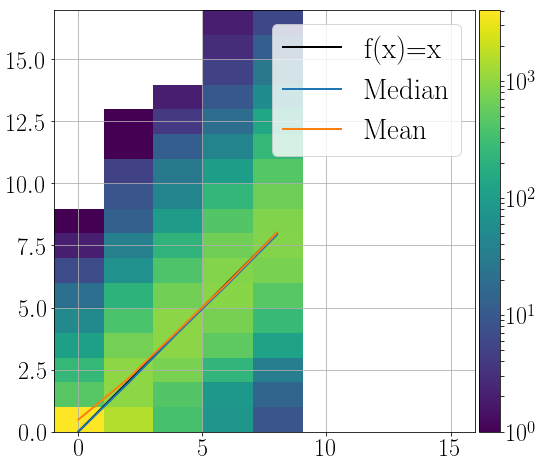

In [26]:
x_bins = np.arange(-0.5*step_size, max_ns+0.5*step_size, step_size)
y_bins = np.arange(0, max(nss_fit), 1)
ttt = plt.figure(figsize=(8, 8))
ttt = plt.hist2d(nss_true, nss_fit, bins=[x_bins, y_bins], norm = mpl.colors.LogNorm())
plt.plot(ns_range, ns_range, color='black', label="f(x)=x")
plt.plot(ns_range, medians, label="Median")
plt.plot(ns_range, means, label="Mean")
ttt = plt.axis("square")
ttt = plt.legend(loc="best")

ax = plt.gca()
from mpl_toolkits.axes_grid1 import make_axes_locatable
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
ttt = plt.colorbar(cax=cax)

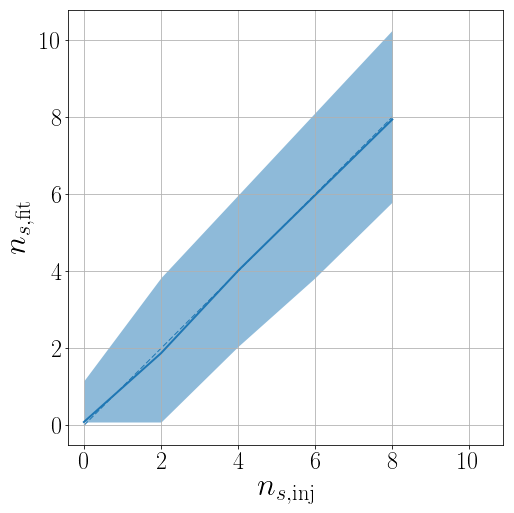

In [27]:
dns = np.mean(np.diff(ns_range))
ns_bins = np.r_[ns_range - 0.5*dns, ns_range[-1] + 0.5*dns]
expect_kw = dict(color='C0', ls='--', lw=1, zorder=-10)

fig = plt.figure(figsize=(8,8))
ax = plt.axes()

h = hl.hist((nss_true, nss_fit), bins=(ns_bins, 100))
sss = hl.plot1d(ax, h.contain_project(1),errorbands=True, drawstyle='default')

plt.plot(ns_range, ns_range, **expect_kw)

plt.axis("square")
ttt = plt.xlabel(r'$n_{s,\mathrm{inj}}$')
ttt = plt.ylabel(r'$n_{s,\mathrm{fit}}$')

In [38]:
inj = trtr.sig_injs[0]
inj.get_frac_during_livetime()

array([1.])

### Calculate the sensitivity

In [12]:
sens = trtr.find_n_sig(ts=0, beta=0.9, coverage=2, n_sig_step=1, n_sig_start = 2, first_batch_size=500, batch_size=5000, mp_cpus=10, tol=0.05, n_batches=10, seed=35762)

# first_batch_size: Batch size used when initially scanning ns
# Coverage: Maximal value of ns that will be used to determine n_sig (relative to the best scan value of ns)

Start time: 2019-10-15 07:04:17.068184
Using 10 cores.
* Starting initial scan for 90% of 500 trials with TS >= 0.000...
  n_sig = 2.000 ... frac = 0.71800
  n_sig = 3.000 ... frac = 0.82200
  n_sig = 4.000 ... frac = 0.89600
  n_sig = 5.000 ... frac = 0.93400
* Generating batches of 5000 trials...
n_trials | n_inj    0.00    1.11    2.22    3.33    4.44    5.56    6.67    7.78    8.89   10.00  |  n_sig(relative error)
5000     |         31.1%   57.3%   75.9%   86.0%   92.1%   95.6%   97.8%   98.6%   99.1%   99.7%  |      3.998 (+/-  1.8%) [spline]
End time: 2019-10-15 07:05:23.703742
Elapsed time: 0:01:06.635558


In [14]:
#print("Acceptance: {}".format(trtr.get_acc_total()))
print("Fluence: {}".format(trtr.to_E2dNdE(sens["n_sig"])))

Fluence: 0.0901151989765
